# Clustering microbiome data using HULK sketches

***

## Commands used to download the data

* Download the CAMI data, store samples in directories labelled by body site

```bash
#!/usr/bin/env bash
# This script downloads the CAMI data, just pipe it the samples you want (Airways, Oral etc.)

dataset=$1
mkdir $1 && cd $_
echo "downloading the ${1} read data from CAMI"
URL="https://openstack.cebitec.uni-bielefeld.de:8080/swift/v1/CAMI_${1}/"
echo "url: ${URL}"

# get the file list
curl ${URL} | grep 'fq.gz' >> reads.list

# download each file in turn and store in sequentially labelled fastqs
COUNTER=1
while read -r line
    do
    download=${URL}${line}
    curl ${download} -o ${COUNTER}.fastq.gz
    COUNTER=$((COUNTER + 1))
    echo "downloaded ${download} and saved to ${COUNTER}.fastq.gz"
    done < reads.list
echo "finished."
```

## Commands used to generate the sketches

* Histosketch each CAMI sample

``` bash
#!/usr/bin/env bash

# This script automates the submission of HULK jobs to the Scafell cluster.
# It will run HULK on each set of CAMI short read samples, storing the sketches for each in a separate directory

# PARAMETERS
## general
CPU=12
QUEUE=scafellpikeSKL
WALL=0:20
SAMPLES=( "Airways" "Gastrointestinal_tract" "Oral" "Skin" "Urogenital_tract" )
## hulk
K=21
S=512

# JOB SUBMISSION
mkdir illumina-hulk-sketches-k${K}-s${S} && cd $_
counter=0
## the cami files are sequentially ordered in each download (1-10 = pacbio, 11-20 = short read)
for i in {11..20}
  do
  for name in "${SAMPLES[@]}"
    do
    outfile=${name}.${i}
    CMD="gunzip -c ../${name}/${i}.fastq.gz | hulk sketch -p ${CPU} -s ${S} -k ${K} -o ${outfile}"
    echo $CMD | bsub -n ${CPU} -R "span[ptile=${CPU}]" -W ${WALL} -q ${QUEUE}
  done
done
```

## Command used to generate pairwise jaccard similarity matrix from the sketches

* This will leave us with a file called `cami.hulk.k21s512.js-matrix.csv` which we then use in this analysis.

```
hulk smash -o cami.hulk.k21s512 --jsMatrix
```

In [19]:
# Pandas for managing datasets
import pandas as pd

# Re for cleaning up data headers
import re

# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

# Seaborn for plotting and styling
import seaborn as sns
sns.set()

In [20]:
# Read dataset
df = pd.read_csv('data/1.clustering/cami.hulk.k21s512.js-matrix.csv')

In [21]:
# Rename columns to just body site
df = df.rename(columns=lambda x: re.sub('.\d+.sketch','',x))
df.head()

,Airways,Urogenital_tract,Urogenital_tract,Airways,Gastrointestinal_tract,Gastrointestinal_tract,Oral,Skin,Gastrointestinal_tract,Oral,...,Oral,Skin,Skin,Skin,Airways,Airways,Gastrointestinal_tract,Gastrointestinal_tract,Gastrointestinal_tract,Urogenital_tract
0,1.00,0.83,0.87,0.92,0.89,0.89,0.86,0.89,0.87,0.85,...,0.85,0.89,0.91,0.90,0.92,0.92,0.86,0.88,0.88,0.87
1,0.83,1.00,0.85,0.85,0.87,0.86,0.83,0.79,0.83,0.81,...,0.79,0.82,0.84,0.81,0.85,0.83,0.83,0.85,0.86,0.83
2,0.87,0.85,1.00,0.88,0.90,0.89,0.87,0.84,0.86,0.84,...,0.84,0.86,0.89,0.87,0.88,0.86,0.87,0.88,0.89,0.93
3,0.92,0.85,0.88,1.00,0.90,0.90,0.87,0.88,0.86,0.84,...,0.85,0.89,0.92,0.89,0.91,0.92,0.88,0.90,0.91,0.88
4,0.89,0.87,0.90,0.90,1.00,0.92,0.90,0.86,0.88,0.85,...,0.87,0.88,0.91,0.88,0.91,0.88,0.89,0.90,0.90,0.87


In [22]:
# Check number of samples for each body site (there should be 10 each, apart from UGT with 8)
df.columns.value_counts()

Gastrointestinal_tract    10
Airways                   10
Skin                      10
Oral                      10
Urogenital_tract           8
dtype: int64

In [23]:
# Convert Jaccard Similarity to percentage
df = df.apply(lambda x: x*100)

In [24]:
# Get the body site labels
sites = pd.Series(df.columns)

In [25]:
# Create a palette to identify the body sites
sites_pal = sns.color_palette("husl", len(sites.unique()))

In [26]:
# Create a lookup table to link palette to body site
lut = dict(zip(sites.unique(), sites_pal))

In [27]:
# Convert the palette to vectors that will be drawn on the side of the matrix
colours = sites.map(lut)

Text(0.5,0.98,'CAMI metagenome hulk sketches clustered by Jaccard Similarity')

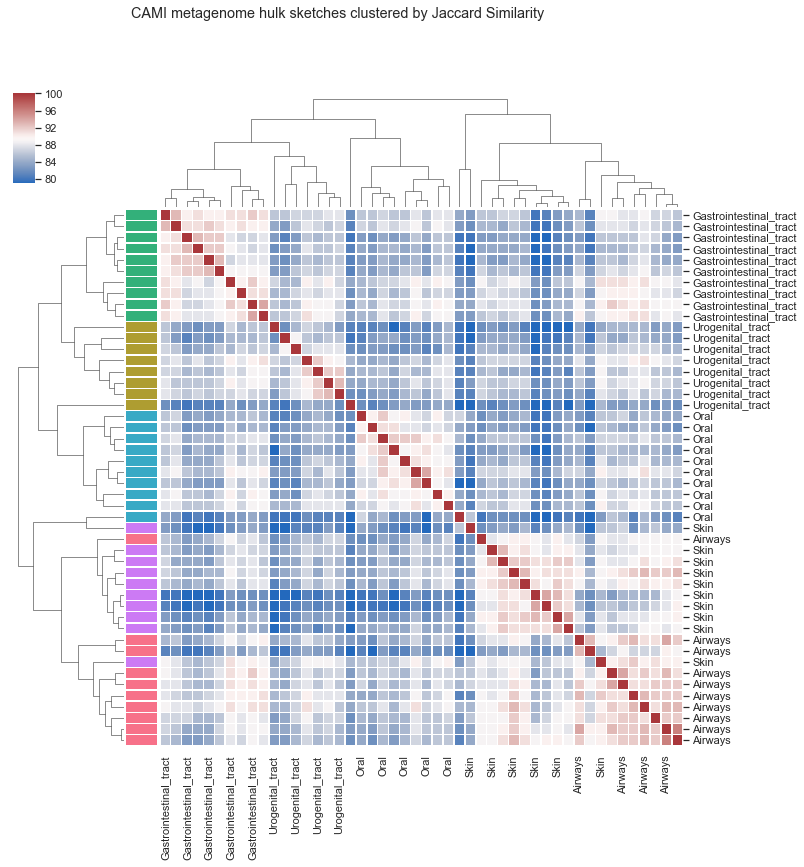

In [28]:
# Plot the clustermap
g = sns.clustermap(df, method='complete', metric='correlation', cmap="vlag",
                   row_colors=colours, row_cluster=True, col_cluster=True, yticklabels=df.columns,
                   robust=True, linewidths=.50, figsize=(12, 12))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
g.fig.suptitle("CAMI metagenome hulk sketches clustered by Jaccard Similarity")

## K-mer spectrum based analysis

### SIMKA commands

* first, you need to generate an input file list
```bash
for site in *; do for i in ./${site}/*.gz; do filename=${i%%.fastq.gz}; echo "${site}.${filename##*/}": `pwd $i`/${site}/${i##*/} >> simka-input.list; done; done
```

* then run SIMKA using LSF with the same LSF parameters as for HULK
```bash
time ./bin/simka -count-file job_count.bash -merge-file job_merge.bash -count-cmd 'bsub -W 0:20 -q scafellpikeSKL' -merge-cmd 'bsub -W 0:20 -q scafellpikeSKL' -kmer-size 21 -complex-dist -in simka-input.list -out RESULTS -out-tmp ./ -max-count 48 -max-merge 48 -nb-cores 576
```

In [29]:
# Read in the SIMKA data, split by semi colon, remove first column (sites), then rename column header by site
df2 = pd.read_csv('data/1.clustering/cami.simka.k21.jd-matrix.csv', delimiter=';')
df2 = df2.rename(columns=lambda x: re.sub('.\d+','',x))
df2.drop('Unnamed:', axis=1, inplace=True)
df2.head()

,Airways,Airways,Airways,Airways,Airways,Airways,Airways,Airways,Airways,Airways,...,Skin,Urogenital_tract,Urogenital_tract,Urogenital_tract,Urogenital_tract,Urogenital_tract,Urogenital_tract,Urogenital_tract,Urogenital_tract,Urogenital_tract
0,0.000000,0.844354,0.846770,0.768394,0.924052,0.843006,0.863186,0.809166,0.799559,0.842687,...,0.917040,0.999280,0.994170,0.999098,0.997985,0.998576,0.998685,0.998438,0.998725,0.998725
1,0.844354,0.000000,0.699148,0.599600,0.666547,0.263017,0.672112,0.534871,0.561771,0.531531,...,0.837769,0.992842,0.989459,0.992289,0.994203,0.997768,0.991983,0.996743,0.993342,0.993342
2,0.846770,0.699148,0.000000,0.593843,0.835176,0.702670,0.643901,0.630967,0.564960,0.558417,...,0.813904,0.988983,0.989133,0.988620,0.992948,0.997671,0.988435,0.997380,0.990205,0.990205
3,0.768394,0.599600,0.593843,0.000000,0.885044,0.596012,0.659391,0.424631,0.413062,0.587845,...,0.881150,0.996500,0.989215,0.996494,0.995416,0.998006,0.996449,0.996713,0.994646,0.994646
4,0.924052,0.666547,0.835176,0.885044,0.000000,0.681987,0.828220,0.756932,0.703095,0.778202,...,0.697060,0.995777,0.989284,0.995368,0.994930,0.997411,0.995666,0.997072,0.994369,0.994369


In [30]:
# Convert Jaccard Distance to similarity
df2 = df2.apply(lambda x: 100-(x*100))

In [37]:
# Set up the plot labelling
sites2 = pd.Series(df2.columns)
colours2 = sites2.map(lut)

Text(0.5,0.98,'CAMI metagenome SIMKA k-mer spectra clustered by Jaccard Similarity')

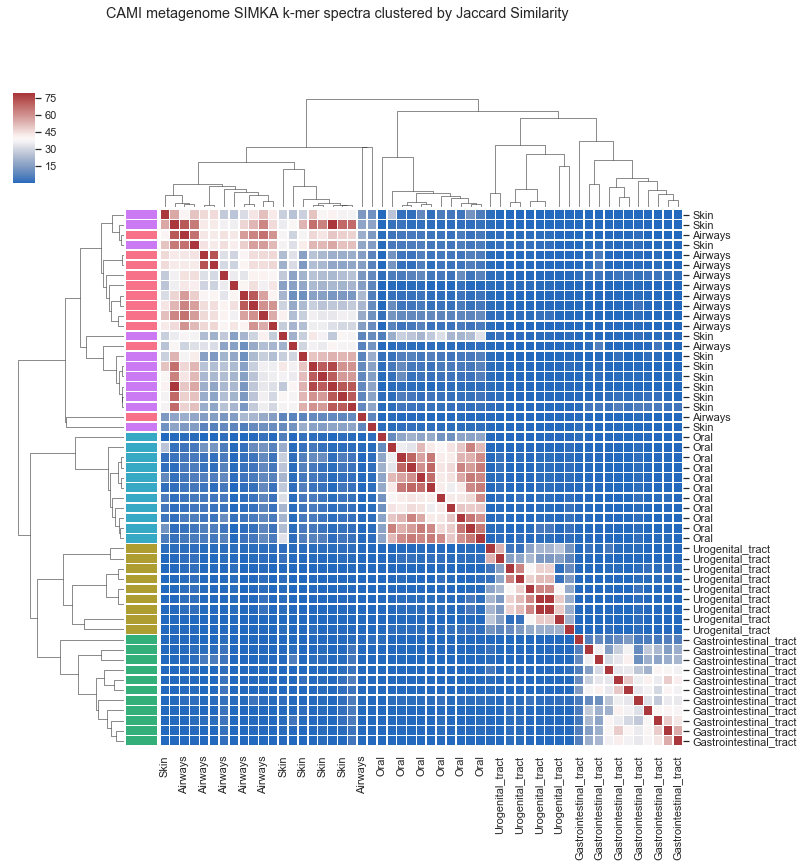

In [38]:
# Plot the clustermap
g2 = sns.clustermap(df2, method='complete', metric='correlation', cmap="vlag",
                   row_colors=colours2, row_cluster=True, col_cluster=True, yticklabels=df2.columns,
                   robust=True, linewidths=.50, figsize=(12, 12))
plt.setp(g2.ax_heatmap.get_yticklabels(), rotation=0)
g2.fig.suptitle("CAMI metagenome SIMKA k-mer spectra clustered by Jaccard Similarity")